
# Test clouds and skimage in a mountain range


### JAH, May 2021

In [26]:
%matplotlib inline
#%matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [27]:
import numpy             as np
import matplotlib.pyplot as plt

import clouds.clouds    as clouds
import clouds.pltclouds as pltclouds

import clouds.ridges      as ridges
import clouds.test_ridges as tridges

In [28]:
plt.rcParams['image.cmap'] = 'rainbow'

In [29]:
import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Fri May 14 17:11:22 2021


## Test

   * Generate a 3D function with know gradient, laplacian, eigenvalues and ridge
   
   * Validate gradient, laplacian, eigenvalues, ridge
   
   * Define a Ridge filter


## Generate Function

## Generate sample

In [30]:
fun = lambda x, y : x - (y-5)**2
xrange = (0, 10)
nbins  = 101

In [31]:
bins, cells, img = tridges.generate_image(nbins, (xrange, xrange), fun)

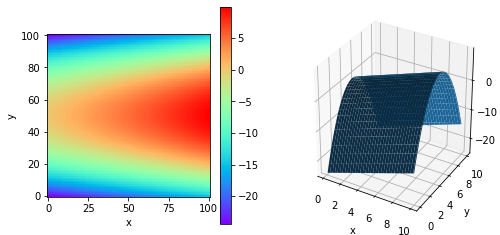

In [32]:
fig = plt.figure(figsize = (8, 4))
ax0  = plt.subplot(1, 2, 1)
p = ax0.imshow(img.T, origin = 'lower');
plt.colorbar(p);
plt.xlabel('x'); plt.ylabel('y');
yms, xms = np.meshgrid(*cells)
ax1 = fig.add_subplot(1, 2, 2, projection = '3d')
ax1.plot_surface(xms, yms, img);
plt.xlabel('x'); plt.ylabel('y');

## Gradient

In [33]:
steps = [bin[1] - bin[0] for bin in bins]
print('steps ', steps)
grad = ridges.gradient(img, steps)
lx, ly = grad[..., 0], grad[..., 1]
#shape = (*lx.shape, 2)
#grad  = np.zeros(shape)
#grad[..., 0] = lx
#grad[..., 1] = ly
print(np.mean(lx), np.mean(ly))
vgrad, phi = np.sqrt(lx + lx + ly * ly), np.arctan2(ly, lx)/np.pi

steps  [0.09900990099009901, 0.09900990099009901]
0.9999999999999998 -2.1063437240844456e-15


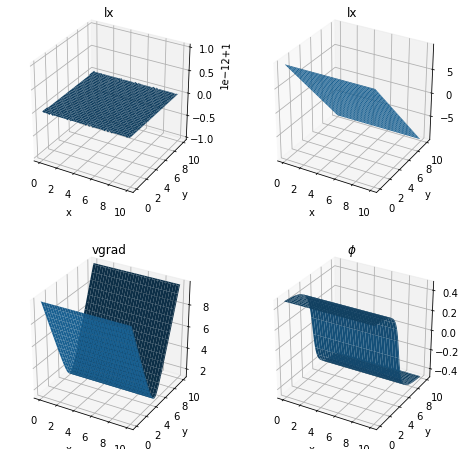

In [34]:
fig = plt.figure(figsize = (8, 8))

ax0 = fig.add_subplot(2, 2, 1, projection = '3d')
ax0.plot_surface(xms, yms, lx)
plt.xlabel('x'); plt.ylabel('y'); plt.title('lx')

ax1 = fig.add_subplot(2, 2, 2, projection = '3d')
ax1.plot_surface(xms, yms, ly);
plt.xlabel('x'); plt.ylabel('y'); plt.title('lx')

ax1 = fig.add_subplot(2, 2, 3, projection = '3d')
ax1.plot_surface(xms, yms, vgrad);
plt.xlabel('x'); plt.ylabel('y'); plt.title('vgrad')

ax1 = fig.add_subplot(2, 2, 4, projection = '3d')
ax1.plot_surface(xms, yms, phi);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'$\phi$');

*Notes*

   * Use the steps when computing the gradient with numpy


## Hessian

In [35]:
hess = ridges.hessian(img, steps)
lxx, lxy, lyy = hess[..., 0, 0], hess[..., 0, 1], hess[..., 1, 1]

In [36]:
leing, eeing, e0 = ridges.hessian_eigh(hess)

In [37]:
#leing, eeing = np.linalg.eigh(hess)
l1, l2 = leing[..., 0], leing[..., 1]

In [38]:
print('eingen values shape ', leing.shape)
print('eingen vector shape ', eeing.shape)

eingen values shape  (101, 101, 2)
eingen vector shape  (101, 101, 2, 2)


In [39]:
kk = grad * e0
uu = np.sum(kk, axis = 2)
uu.shape

(101, 101)

In [40]:
e0x, e0y = e0[..., 0], e0[..., 1]
beta     = np.arctan2(e0y, e0x)/np.pi

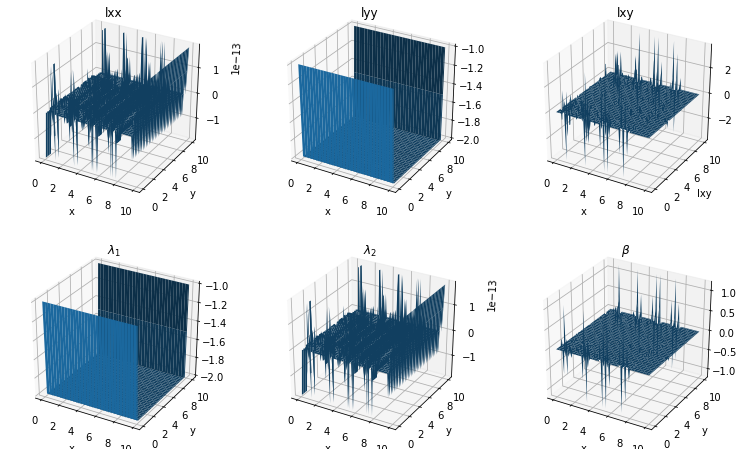

In [41]:
fig = plt.figure(figsize = (13, 8))

ax0 = fig.add_subplot(2, 3, 1, projection = '3d')
ax0.plot_surface(xms, yms, lxx)
plt.xlabel('x'); plt.ylabel('y'); plt.title('lxx')

ax1 = fig.add_subplot(2, 3, 2, projection = '3d')
ax1.plot_surface(xms, yms, lyy);
plt.xlabel('x'); plt.ylabel('y'); plt.title('lyy')

ax1 = fig.add_subplot(2, 3, 3, projection = '3d')
ax1.plot_surface(xms, yms, lxy);
plt.xlabel('x'); plt.ylabel('lxy'); plt.title('lxy')

ax1 = fig.add_subplot(2, 3, 4, projection = '3d')
ax1.plot_surface(xms, yms, l1);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'$\lambda_1$');

ax1 = fig.add_subplot(2, 3, 5, projection = '3d')
ax1.plot_surface(xms, yms, l2);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'$\lambda_2$');

ax1 = fig.add_subplot(2, 3, 6, projection = '3d')
ax1.plot_surface(xms, yms, beta);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'$\beta$');

**Note**

   * To avoid edge problems, maybe extend the cells of clouds (+2, -2)

## Ridge

   * The main einvalue is the last one
  
   * Compute the scalar product with the unitary gradient
 

In [42]:
imax = np.argmax(leing, axis = 2)
print(imax)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [45]:
e0x, e0y = e0[..., 0], e0[..., 1]
beta = np.arctan2(e0y, e0x)/np.pi
#print(beta)
#print(e0x * e0x + e0y * e0y)

gx , gy = lx, ly
phi  = np.arctan2(gy, gx)/np.pi
#print(phi)
#print(gx * gx + gy * gy)

uu = (e0x * gx + e0y * gy)/vgrad
theta = np.arccos(uu)/np.pi
#print(np.min(theta))
#print(np.max(uu))

#print(np.min(np.abs(beta - phi)))

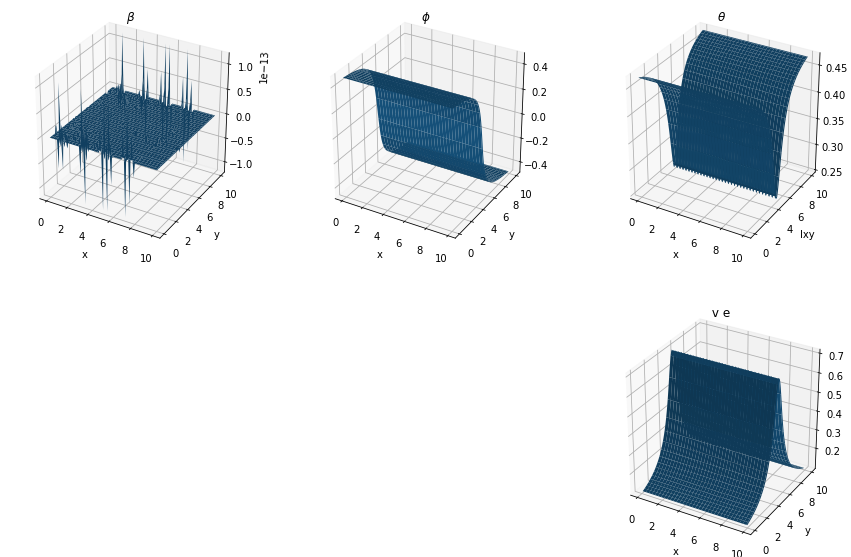

In [46]:
fig = plt.figure(figsize = (15, 10))

ax0 = fig.add_subplot(2, 3, 1, projection = '3d')
ax0.plot_surface(xms, yms, beta)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'$\beta$')

ax1 = fig.add_subplot(2, 3, 2, projection = '3d')
ax1.plot_surface(xms, yms, phi);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'$\phi$')

ax1 = fig.add_subplot(2, 3, 3, projection = '3d')
ax1.plot_surface(xms, yms, theta);
plt.xlabel('x'); plt.ylabel('lxy'); plt.title(r'$\theta$')

#ax1 = fig.add_subplot(2, 3, 4, projection = '3d')
#ax1.plot_surface(xms, yms, l1);
#plt.xlabel('x'); plt.ylabel('y'); plt.title(r'$\lambda_1$');
ax1 = fig.add_subplot(2, 3, 6, projection = '3d')
ax1.plot_surface(xms, yms, uu);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r' v e ');

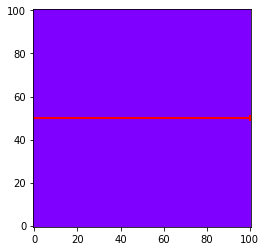

In [47]:
ucut = np.percentile(uu, 99.)
sel  = (uu >= ucut) & (l1 < l2)
plt.imshow(sel.T, origin = 'lower');

In [48]:
urid  = ridges.ridge(img, steps)
uu    = ridges.ridge_filter(img, steps, 99)

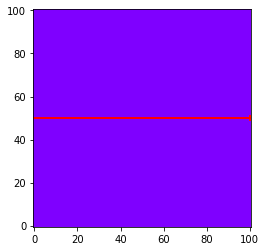

In [49]:
plt.imshow(uu.T, origin = 'lower');

In [50]:
lap = ridges.laplacian(hess)

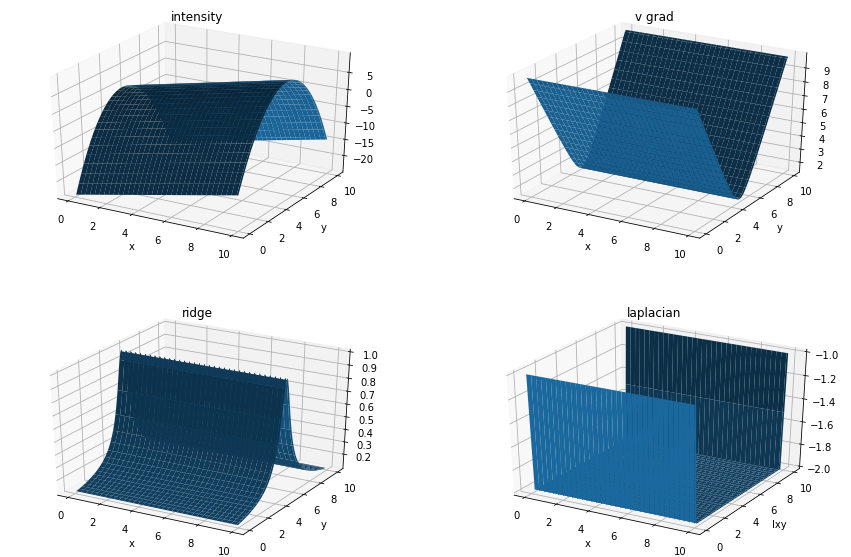

In [51]:
fig = plt.figure(figsize = (15, 10))

ax0 = fig.add_subplot(2, 2, 1, projection = '3d')
ax0.plot_surface(xms, yms, img)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'intensity')

ax1 = fig.add_subplot(2, 2, 2, projection = '3d')
ax1.plot_surface(xms, yms, vgrad);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'v grad')

ax1 = fig.add_subplot(2, 2, 3, projection = '3d')
ax1.plot_surface(xms, yms, urid);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'ridge')

ax1 = fig.add_subplot(2, 2, 4, projection = '3d')
ax1.plot_surface(xms, yms, lap);
plt.xlabel('x'); plt.ylabel('lxy'); plt.title(r'laplacian');

## 3D

In [97]:
fun = lambda x, y, z : x - (y - 5)**2 - (z - 3)**2
xrange = (0, 10)
nbins  = 41

In [98]:
bins, cells, img = tridges.generate_image(nbins, (xrange, xrange, xrange), fun)

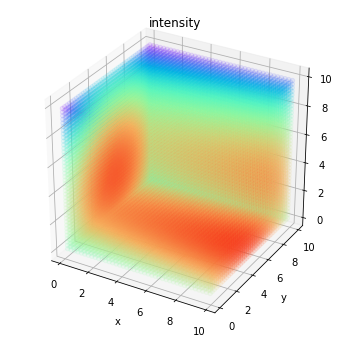

In [99]:
fig = plt.figure(figsize = (6, 6))
ax  = fig.add_subplot(1, 1, 1, projection = '3d')
mcells = np.meshgrid(*cells)
mcells.reverse()
p = ax.scatter(*mcells, '.', c = img.flatten(), alpha = 0.1);
plt.xlabel('x'); plt.ylabel('y'); plt.title('intensity');

In [100]:
steps = [bin[1] - bin[0] for bin in bins] 
grad  = ridges.gradient(img, steps)
vgrad = np.sqrt(np.sum(grad * grad, axis = 3))
hess  = ridges.hessian (img, steps)
leig, eeig, e0 = ridges.hessian_eigh(hess)
ride  = ridges.ridge(img, steps)
lap   = ridges.laplacian(hess)

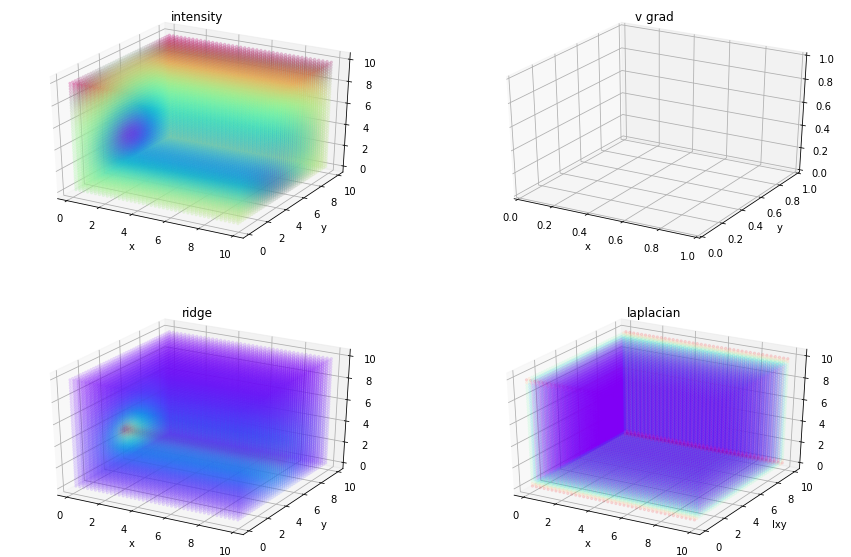

In [101]:
fig = plt.figure(figsize = (15, 10))

ax0 = fig.add_subplot(2, 2, 1, projection = '3d')
ax0.scatter(*mcells, c = img.flatten(), marker = '.', alpha = 0.1)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'intensity')

ax9 = fig.add_subplot(2, 2, 2, projection = '3d')
ax0.scatter(*mcells, c = vgrad.flatten(), marker = '.', alpha = 0.1)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'v grad')

ax0 = fig.add_subplot(2, 2, 3, projection = '3d')
ax0.scatter(*mcells, c = ride.flatten(), marker = '.', alpha = 0.1)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'ridge')

ax0 = fig.add_subplot(2, 2, 4, projection = '3d')
ax0.scatter(*mcells, c = lap.flatten(), marker = '.', alpha = 0.1)
plt.xlabel('x'); plt.ylabel('lxy'); plt.title(r'laplacian');

In [105]:
uu = ridges.ridge_filter(img, steps, 99)
print(uu.shape)

(41, 41, 41)


In [106]:
cells_select = clouds.cells_select

Text(0.5, 0.92, 'intensity')

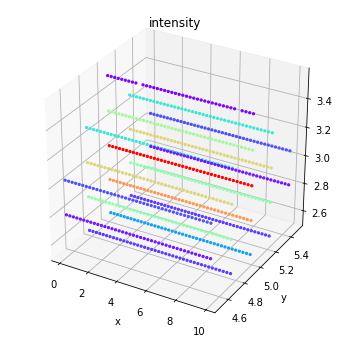

In [107]:
fig = plt.figure(figsize = (6, 6))
sel = uu > 0

ax0 = fig.add_subplot(1, 1, 1, projection = '3d')
ax0.scatter(*cells_select(mcells, sel), c = uu[sel], marker = '.', alpha = 1.)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'intensity')

### Dispersion in the ortoganal gradient direction